## MobileNetV2 implementation using tensorflow

- A new convolution block called **Inverted Residuals and Linear Bottlenecks** was introduced. In this block, **the features from a lower dimensional representation are scaled up. Then a Depthwise convolution is applied and then the features are compressed back** into the earlier lower dimensional representation.

In [46]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, DepthwiseConv2D, ReLU, BatchNormalization, Add, GlobalAvgPool2D
from tensorflow.keras.models import Model

In [88]:
def expansion_layer(x, t, filters):
  """
  1x1 convolution
  The expansion of the layer is decided by a scalar variable t.
  This variable is multiple by the filter size to get the desired expansion


  Args:
    x - input
    t - expansion variable
    filters - no of filters
  """
  total_filters = t * filters
  x = Conv2D(filters=total_filters,
             kernel_size=1,
             strides=1,
             padding='same',
             use_bias=False
             )(x)
  x = BatchNormalization()(x)
  x = ReLU(max_value=6)(x)
  return x


In [89]:
def projection_layer(x, out_channels):
  """
  1x1 convolution
  The compression is decided the output layer we want i.e. the filter size.
  No Activation layer after the batch normalization layer in the Projection layer as it would destroy useful information.

  Args:
    x : input
    out_channels : Number of output channels. used for compression.
  """
  x = Conv2D(filters=out_channels,
             kernel_size=1,
             strides=1,
             padding='same',
             use_bias=False)(x)
  x = BatchNormalization()(x)
  return x

In [90]:
def depthwise_conv(x, strides=1):
  """
  Args:
    x : input
    strides : strides for depthwise convolution
  """
  x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = ReLU(6)(x)
  return x


In [97]:
def bottleneck_block(x, t, filters, out_channels, strides):
  """
  Expansion -> Depthwise -> Projection/Compression

  Args:
    x : input
    t : expansion factor
    filters : Number of filters
    out_channels : Num of output channels for compression
    strides : Stride for convolution
  """
  y = expansion_layer(x, t, filters)
  y = depthwise_conv(y, strides)
  y = projection_layer(y, out_channels)

  # The layer addition can only be done when the channel size is the same.
  if y.shape[-1] == x.shape[-1]:
    y = Add()([x,y])
  return y

In [104]:
def mobilenetv2(input_shape=(224,224,3), num_classes=10):
  """
  Tensorflow implementation of MobilenetV2 architecture
  """

  input = Input(shape=input_shape)

  x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same', use_bias=False)(input)
  x = BatchNormalization()(x)
  x = ReLU(6)(x)

  # chain of 17 Bottlenecks
  x = depthwise_conv(x, strides=1)
  x = projection_layer(x, out_channels=16)

  x = bottleneck_block(x, t=6, filters=x.shape[-1], out_channels=24, strides=1)
  x = bottleneck_block(x, t=6, filters=x.shape[-1], out_channels=24, strides=1)

  x = bottleneck_block(x, t=6, filters=x.shape[-1], out_channels=32, strides=2)
  x = bottleneck_block(x, t=6, filters=x.shape[-1], out_channels=32, strides=1)
  x = bottleneck_block(x, t=6, filters=x.shape[-1], out_channels=32, strides=1)

  x = bottleneck_block(x, t=6, filters=x.shape[-1], out_channels=64, strides=2)
  x = bottleneck_block(x, t=6, filters=x.shape[-1], out_channels=64, strides=1)
  x = bottleneck_block(x, t=6, filters=x.shape[-1], out_channels=64, strides=1)
  x = bottleneck_block(x, t=6, filters=x.shape[-1], out_channels=64, strides=1)

  x = bottleneck_block(x, t=6, filters=x.shape[-1], out_channels=96, strides=1)
  x = bottleneck_block(x, t=6, filters=x.shape[-1], out_channels=96, strides=1)
  x = bottleneck_block(x, t=6, filters=x.shape[-1], out_channels=96, strides=1)

  x = bottleneck_block(x, t=6, filters=x.shape[-1], out_channels=160, strides=2)
  x = bottleneck_block(x, t=6, filters=x.shape[-1], out_channels=160, strides=1)
  x = bottleneck_block(x, t=6, filters=x.shape[-1], out_channels=160, strides=1)

  x = bottleneck_block(x, t=6, filters=x.shape[-1], out_channels=320, strides=1)

  x = Conv2D(filters=1280, kernel_size=1, padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = ReLU(6)(x)

  x = GlobalAvgPool2D()(x)
  output = Dense(num_classes, activation='softmax')(x)

  model = Model(input, output)
  return model

In [105]:
INPUT_SHAPE = (224,224,3)
NUM_CLASSES = 1000

model = mobilenetv2(input_shape = INPUT_SHAPE, num_classes=NUM_CLASSES)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_35 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_154 (Conv2D)         (None, 112, 112, 32)         864       ['input_35[0][0]']            
                                                                                                  
 batch_normalization_226 (B  (None, 112, 112, 32)         128       ['conv2d_154[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 re_lu_147 (ReLU)            (None, 112, 112, 32)         0         ['batch_normalization_22

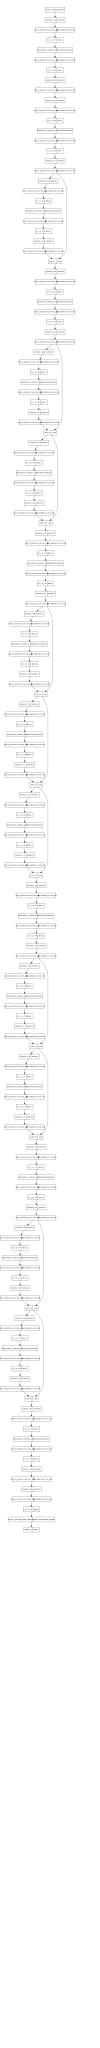

In [106]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot


SVG(model_to_dot(model).create(prog='dot', format='svg'))

### References
- [Creating MobileNetsV2 with TensorFlow from scratch](https://medium.com/analytics-vidhya/creating-mobilenetsv2-with-tensorflow-from-scratch-c85eb8605342)